### 1. 加载模块

In [1]:
%load_ext autoreload
%autoreload 2
from utils import load_all
from Loss_Function import compute_ciou_loss, DFL_loss
from Model import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import config


### 2.测试csv

In [2]:
# image, csv = load_all(config.DIRPATH)

In [3]:
# csv_slice = csv[3].iloc[:, 3:].values
# csv

### 3. 定义Dataset

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
class_to_index = {
    'E2': 0, 'B52': 1, 'B2': 2, 'Mirage2000': 3, 'F4': 4,
    'F14': 5, 'Tornado': 6, 'J20': 7, 'JAS39': 8
}

class MyDataset(Dataset):
    '''
    将图片和[class, Bbox]转化为Tensor
    返回值：
    1. image: [bs, 640, 640, 3]
    2. target: [bs, 物品个数, class, xmin, ymin, xmax, ymax]
    '''
    def __init__(self, path, transform):
        super().__init__()
        self.image, self.csv = load_all(path)
        self.transform = transform
    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        image = self.transform(self.image[index])
        csv = self.csv[index]
        # filename width height class xmin ymin xmax ymax
        target_array = csv.iloc[:, 3:].values
        target_class = torch.zeros((8400, 9))
        target_bbox = torch.zeros((8400, 4))
        for i in range(len(target_array)):
            target_class[i][class_to_index[target_array[i][0]]] = 1
            target_bbox[i, 0] = target_array[i][1]
            target_bbox[i, 1] = target_array[i][2]
            target_bbox[i, 2] = target_array[i][3]
            target_bbox[i, 3] = target_array[i][4]

        return image, target_class, target_bbox

### 4. 定义Dataloader, net, Loss_Function, optimizer

In [5]:
dataset = MyDataset(config.DIRPATH, data_transform)

In [6]:
device = torch.device('cuda')
# device = torch.device('cpu')
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True)
F1 = nn.BCELoss()
F2 = compute_ciou_loss
F3 = DFL_loss
reg_max, num_class = 1, 9


In [7]:
net = Model(reg_max, num_class).to(device)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.937)
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)

### 5. 训练过程

In [8]:
torch.cuda.empty_cache()

In [9]:
max_epoch = 1
all_loss = []
for epoch in range(max_epoch):
    losses, n = 0, 0
    for i, (image, target_class, target_bbox) in enumerate(dataloader):
        image = image.to(device)

        target_class = target_class.to(device)
        target_bbox = target_bbox.to(device)
        BLS1, CLS1, BLS2, CLS2, BLS3, CLS3 = net(image)
        print(i)
        BLS1 = BLS1.flatten(2).transpose(1, 2)
        BLS2 = BLS2.flatten(2).transpose(1, 2)
        BLS3 = BLS3.flatten(2).transpose(1, 2)
        CLS1 = CLS1.flatten(2).transpose(1, 2)
        CLS2 = CLS2.flatten(2).transpose(1, 2)
        CLS3 = CLS3.flatten(2).transpose(1, 2)
        BLS = torch.cat((BLS1, BLS2, BLS3), dim=1) # [bs, 8400, 4]
        CLS = torch.cat((CLS1, CLS2, CLS3), dim=1) # [bs, 8400, 9]
        # print(BLS)
        # print(CLS)

        # CLS = nn.Sigmoid()(CLS)
        # CLS_loss = F1(CLS, target_class) # 计算分类损失
        
        CiOU_out = F2(BLS, target_bbox)
        print(CiOU_out)
        if(i==1):
            break
        CiOU_loss = torch.sum(CiOU_out[~torch.isnan(CiOU_out)]) # 计算边框回归损失
        for name,params in net.named_parameters():
            if torch.isnan(params).any():
                print(name)
        # DFL_loss = F3(BLS, target_bbox) # 计算中心点回归损失
        alpha = 0.4
        Loss=alpha*CiOU_loss
        # Loss=(1-alpha)*DFL_loss 
        # Loss=CLS_loss
        # Loss = CLS_loss + alpha*CiOU_loss + (1-alpha)*DFL_loss # 计算总Loss
        # print(Loss.item())
        losses += Loss.item()
        n += target_bbox.shape[0]
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    print(f'epoch = {epoch}, Loss = {losses / n:.4f}')
    all_loss.append(losses / n)

0
torch.Size([4, 8400])
tensor([[3.1692,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.0060,    nan,    nan,  ...,    nan,    nan,    nan],
        [3.2651, 2.2163,    nan,  ...,    nan,    nan,    nan],
        [2.1332,    nan,    nan,  ...,    nan,    nan,    nan]],
       grad_fn=<MulBackward0>)
tensor([[1.2602,    nan,    nan,  ...,    nan,    nan,    nan],
        [0.5060,    nan,    nan,  ...,    nan,    nan,    nan],
        [1.2657, 1.1892,    nan,  ...,    nan,    nan,    nan],
        [1.1809,    nan,    nan,  ...,    nan,    nan,    nan]],
       grad_fn=<SubBackward0>)
1
torch.Size([4, 8400])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<MulBackward0>)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ...,

### 6. 绘制Loss图

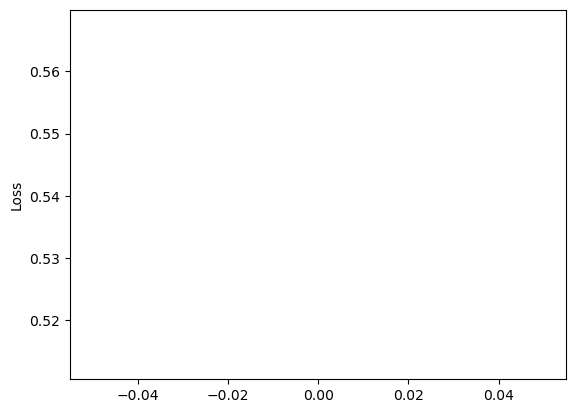

In [10]:
plt.plot(all_loss, color='blue')
plt.ylabel('Loss')
plt.show()
